The goal here is to evaluate the values and compute the number of bits that are being modified by adversarial training.

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [20]:
orig_weights = np.load('original_weights.npy')
modified_weights = np.load('modified_weights.npy')

In [26]:
def compute_minAndMax(list_arrays):
    min_val = np.inf
    max_val = -np.inf
    for arr in list_arrays:
        if arr.min() < min_val:
            min_val = arr.min()
        if arr.max() > max_val:
            max_val = arr.max()
    return min_val, max_val

In [22]:
def compute_scalingFunction(list_weightArrays, N) :
    """
    returns as functions which computes :
                N * (x - min)
        f(x) = ------------
                max - min
    """
    min_val, max_val = compute_minAndMax(list_weightArrays)
    factor = N / (max_val - min_val)
    return lambda x : N * (x - min_val)/(max_val - min_val)

In [23]:
def scale_weights(list_weightArrays, scale_func, N):
    """
    scale the weight values so that they are large integers
    which can be manipulated with bitwise operators
    """
    list_scaledWeightArrays = []
    for arr in list_weightArrays:
        scaledArray = scale_func(arr)
        list_scaledWeightArrays.append(scaledArray.astype(int))
    return list_scaledWeightArrays

In [24]:
def compute_bitErrorRate(list_origWeights, list_modifiedWeights, N):
    list_weightArrays = list_origWeights + list_modifiedWeights
    scale_func = compute_scalingFunction(list_weightArrays, N)
    scaled_origWeights = scale_weights(list_origWeights, scale_func, N)
    scaled_modifiedWeights = scale_weights(list_modifiedWeights, scale_func, N)
    list_bitErrorRates = []
    for orig_arr, modified_arr in zip(scaled_origWeights, scaled_modifiedWeights):
        error_arr = orig_arr ^ modified_arr
        list_bitErrorRates.append(error_arr)
    return list_bitErrorRates

In [43]:
l = compute_bitErrorRate(orig_weights, modified_weights, 15)
compute_minAndMax(l)

(0, 15)

In [39]:
def visualize(list_arrays):
    flattenedArray = np.array([])
    for arr in list_arrays:
        flattenedArray = np.append(flattenedArray, np.reshape(arr, (-1,)))
    print(flattenedArray.shape)
    print(flattenedArray.min())
    print(flattenedArray.max())
    h = plt.hist(flattenedArray, 20)
    plt.show()
    h = plt.hist(flattenedArray[flattenedArray > 0], 20)
    plt.show()

(402528,)
0.0
15.0


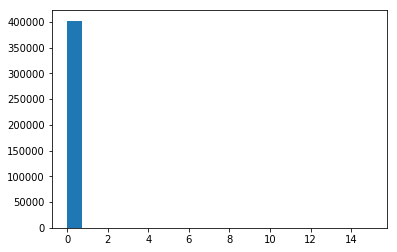

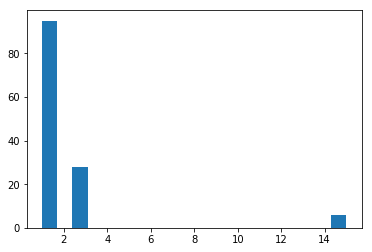

In [44]:
visualize(l)